# Find nearest neighbourg Color in Pickes from  Auxtel Photometric data 

- author Sylvie Dagoret-Campagne
- creation date : 2024/08/01
- update : 2024/08/01 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

from astropy.io import fits

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


In [2]:
from scipy import interpolate
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree, BallTree

In [3]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Be sure to run this notebook in conda environment named conda_py310


## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran Emulator

In [4]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [5]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo("AUXTEL")

AUXTEL site name validated as LSST observatory


In [6]:
WL = emul.GetWL()

#### Library to fit atmosphere

In [7]:
import sys
sys.path.append('../lib')
#import libAtmosphericFit

#### Library that encapsulate calculations for Photometric correction

In [8]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


In [9]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [10]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

#### library rubin_sim defining LSST parameters, namely for photometric calculations

In [11]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

## Configuration

In [12]:
am0 =1.20    # airmass
pwv0 = 3.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [13]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

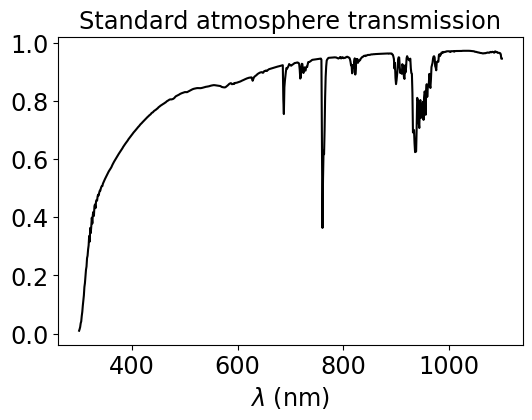

In [14]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

### Check LSST instrument throughput

Photometric Correction package should find the instrumental passband of LSST

Text(0.5, 1.0, 'Instrument throughput (auxtel)')

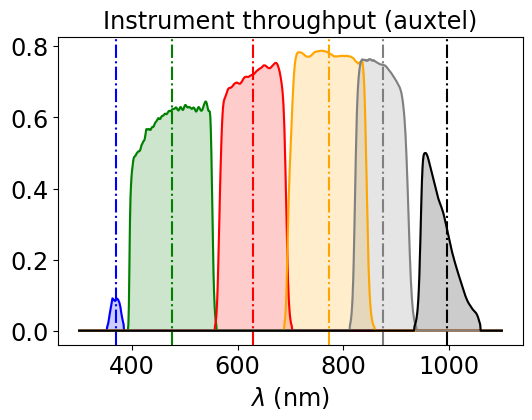

In [15]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput (auxtel)")

### Check LSST standard Filter throughputs

Text(0.5, 1.0, 'Total filter throughput (auxtel)')

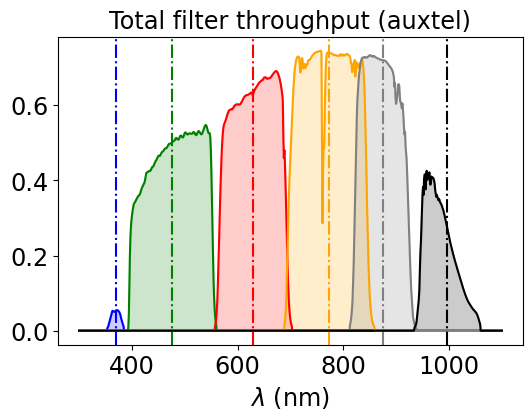

In [16]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput (auxtel)")

## Variation of PWV

In [17]:
am = 1.2
oz = 300
tau= 0.04
beta = 1
all_pwv = np.arange(0,10,0.5)
NPWV = len(all_pwv)

In [18]:
pc.CalculateMultiObs(am,all_pwv,oz,tau,beta)

### PWV variation :  Observed filter and normalized response

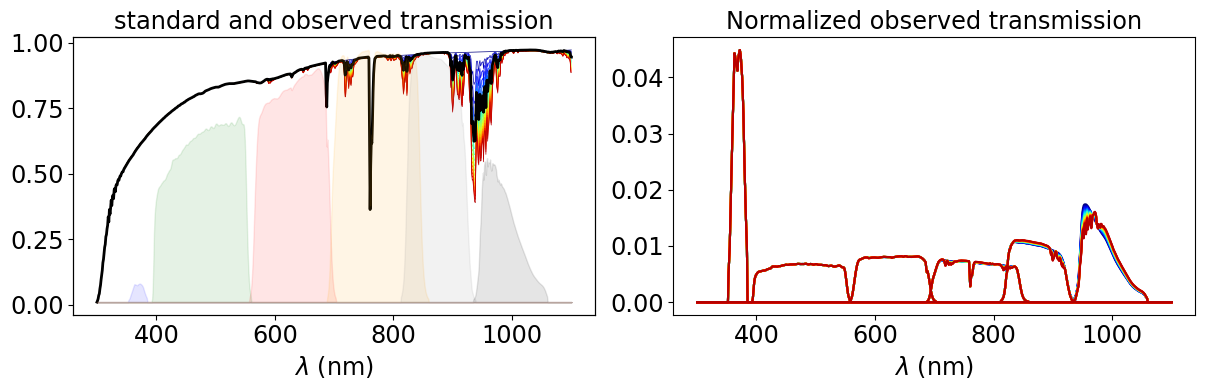

In [19]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,4))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,pwv in enumerate(all_pwv):
  
    atm = pc.coll_atm_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_pwv,pwv in enumerate(all_pwv):
    
    
    label = f"pwv={pwv:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_pwv][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  


plt.tight_layout()
plt.show()



## SED

In [20]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')

In [21]:
seddir = os.path.join(fdir, 'pysynphot', 'pickles')

In [22]:
seddir_uvi = os.path.join(seddir,"dat_uvi")
seddir_uvk = os.path.join(seddir,"dat_uvk")

In [23]:
all_pickles_uvi = sorted(os.listdir(seddir_uvi))
all_pickles_uvk = sorted(os.listdir(seddir_uvk))

In [24]:
file_ref = os.path.join(seddir_uvk, "pickles_uk.fits")

In [25]:
hdul = fits.open(file_ref)

In [26]:
df_pickle = pd.DataFrame(hdul[1].data)

In [27]:
df_pickle

,FILENAME,SPTYPE
0,pickles_uk_1,O5V
1,pickles_uk_2,O9V
2,pickles_uk_3,B0V
3,pickles_uk_4,B1V
4,pickles_uk_5,B3V
...,...,...
126,pickles_uk_127,G8I
127,pickles_uk_128,K2I
128,pickles_uk_129,K3I
129,pickles_uk_130,K4I


In [28]:
NSED = len(df_pickle)

In [29]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_62038/1274266691.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_xticklabels(labels,rotation=45);
/Users/dagoret/anaconda3/envs/conda_py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


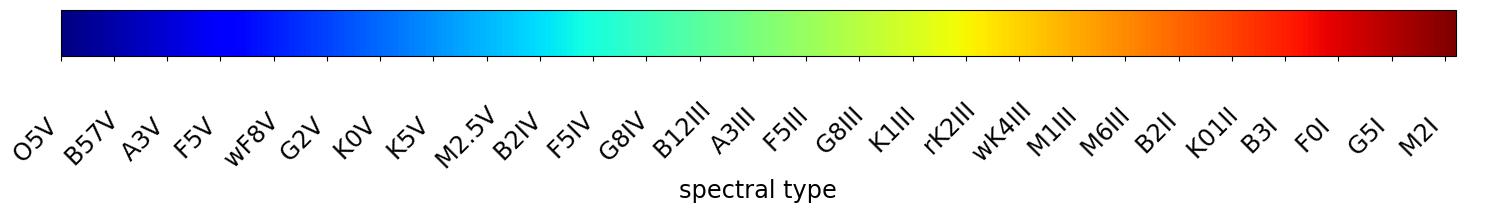

In [30]:
fig, ax = plt.subplots(figsize=(18, 0.6), layout='constrained')
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=NSED)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=ax, orientation='horizontal', label='spectral type')

# change the number of labels
labels = [item.get_text() for item in cbar.ax.get_xticklabels()]
cbar.ax.locator_params(axis='x', nbins=4*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_xticklabels()]

# rename the labels
Nlabels = len(labels)
for ilab in range(0,Nlabels-1):
    the_label = int(labels[ilab])
    labels[ilab] = df_pickle.loc[the_label,"SPTYPE"]
cbar.ax.set_xticklabels(labels,rotation=45);
plt.show()

Text(0.5, 0, '$\\lambda \\, (\\AA$)')

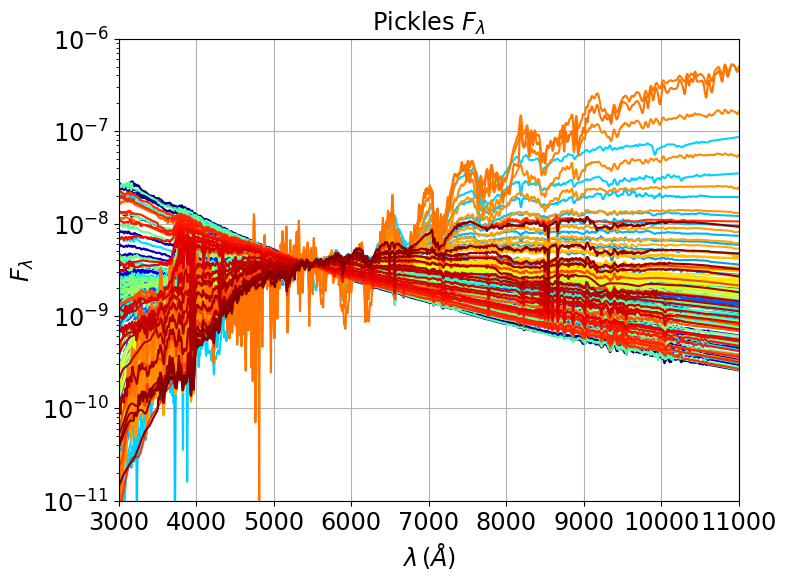

In [31]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
for index in np.arange(NSED):
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    fullfilename = os.path.join(seddir_uvk,filename) 
    hdul = fits.open(fullfilename)
    dff = pd.DataFrame(hdul[1].data)
    if index <= 103 or index >= 105:
        ax.plot(dff.WAVELENGTH,dff.FLUX,color=all_colors[index])
ax.set_yscale('log')
ax.set_xlim(3000.,11000)
ax.set_ylim(1e-11,1e-6)
ax.grid()
ax.set_title("Pickles $F_\lambda$")
ax.set_ylabel("$F_\lambda$")
ax.set_xlabel("$\lambda \, (\AA$)")
#plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
#ax.collections[-1].colorbar


## Convert SED in rubinsim format

In [32]:
all_sed = []
zmag = 20.0
for index in np.arange(NSED):
    spectype = df_pickle.loc[index,"SPTYPE"].strip()
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    fullfilename = os.path.join(seddir_uvk,filename) 
    hdul = fits.open(fullfilename)
    dff = pd.DataFrame(hdul[1].data)
    wl= dff.WAVELENGTH.values
    flux = dff.FLUX.values
    #wavelen (nm)
    #flambda (ergs/cm^2/s/nm)
    the_sed = Sed(wavelen=wl/10., flambda=flux*10., name=spectype)
    flux_norm = the_sed.calc_flux_norm(zmag, pc.bandpass_total_std['r'])
    the_sed.multiply_flux_norm(flux_norm)
    all_sed.append(the_sed) 

### Check the calculation of the Magnitude and the ADC counts (observation)

In [33]:
the_sed1 = all_sed[0]
flux_norm = the_sed1.calc_flux_norm(zmag, pc.bandpass_total_std['r'])
the_sed1.multiply_flux_norm(flux_norm)

the_sed2 = all_sed[-1]
flux_norm = the_sed2.calc_flux_norm(zmag, pc.bandpass_total_std['r'])
the_sed2.multiply_flux_norm(flux_norm)

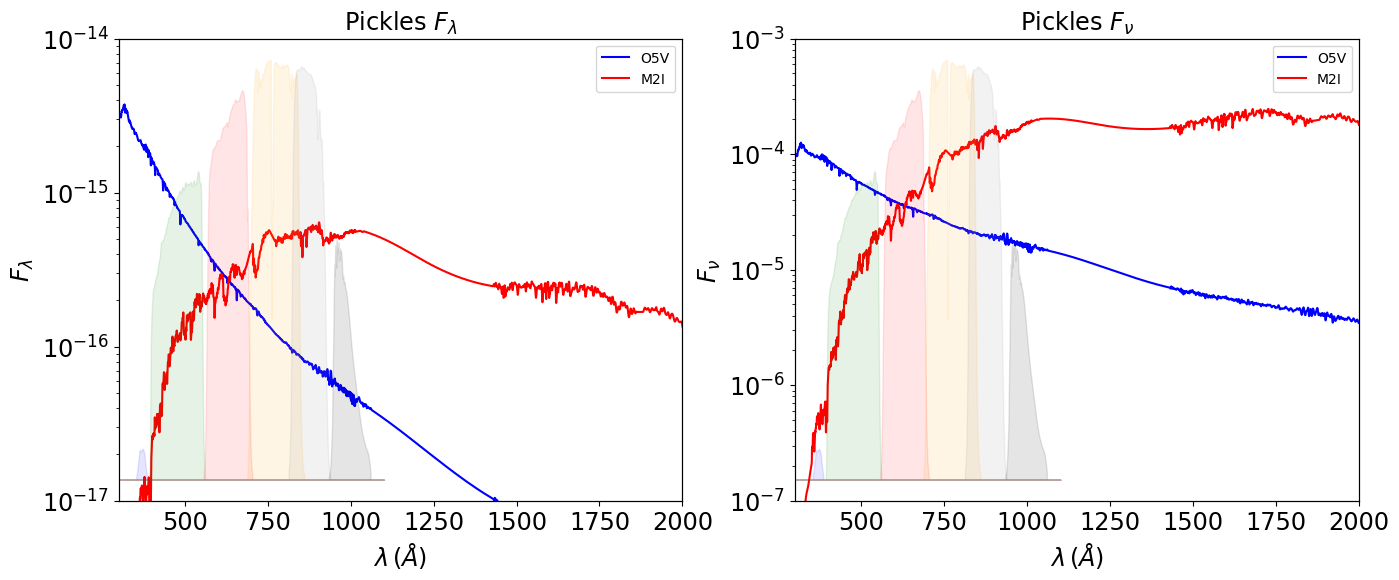

In [34]:
fig,(ax,ax2) = plt.subplots(1,2,figsize=(16,6))
ax.plot(the_sed1 .wavelen,the_sed1 .flambda,"b-",label=the_sed1.name)
ax.plot(the_sed2.wavelen,the_sed2.flambda,"r-",label=the_sed2.name)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-17,1e-14)
ax.set_xlim(300.,2000.)
ax.set_title("Pickles $F_\lambda$")
ax.set_ylabel("$F_\lambda$")
ax.set_xlabel("$\lambda \, (\AA$)")


ax2.plot(the_sed1 .wavelen,the_sed1.fnu,"b-",label=the_sed1.name)
ax2.plot(the_sed2.wavelen,the_sed2.fnu,"r-",label=the_sed2.name)
ax2.set_yscale("log")
ax2.legend()
ax2.set_ylim(1e-7,1e-3)
ax2.set_xlim(300.,2000.)
ax2.set_title("Pickles $F_\\nu$")
ax2.set_ylabel("$F_\\nu$")
ax2.set_xlabel("$\lambda \, (\AA$)")

ax3 = ax.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax3.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax3.set_yticks([])
    
ax4 = ax2.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax4.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax4.set_yticks([])

In [35]:
mags_std1 = {}
for index,f in enumerate(filter_tagnames) :
    mags_std1[f] = the_sed1.calc_mag(pc.bandpass_total_std[f])
mags_std1["g-r"] = mags_std1["g"]- mags_std1["r"]  
mags_std1["z-y"] = mags_std1["z"]- mags_std1["y"]   
df1 = pd.DataFrame(mags_std1, index=[the_sed1.name]).T

mags_std2 = {}
for index,f in enumerate(filter_tagnames) :
    mags_std2[f] = the_sed2.calc_mag(pc.bandpass_total_std[f])
mags_std2["g-r"] = mags_std2["g"]- mags_std2["r"]  
mags_std2["z-y"] = mags_std2["z"]- mags_std2["y"]   
df2 = pd.DataFrame(mags_std2, index=[the_sed2.name]).T
dfa =pd.concat([df1,df2],axis=1)
dfa

,O5V,M2I
u,18.959203,24.703048
g,19.402100,21.502857
r,20.000000,20.000000
i,20.400749,18.936382
z,20.646363,18.540355
y,20.848755,18.303926
g-r,-0.597900,1.502857
z-y,-0.202393,0.236429


In [36]:
photoparams = set_photometric_parameters(30, 1 , readnoise=None)
adcs_stdmag1 = {}
for index,f in enumerate(filter_tagnames) :
    adcs_stdmag1[f] = -2.5*np.log10(the_sed1.calc_adu(pc.bandpass_total_std[f],photoparams))
adcs_stdmag1["g-r"] = adcs_stdmag1["g"]- adcs_stdmag1["r"]  
adcs_stdmag1["z-y"] = adcs_stdmag1["z"]- adcs_stdmag1["y"]      
df1 = pd.DataFrame(adcs_stdmag1, index=[the_sed1.name]).T

adcs_stdmag2 = {}
for index,f in enumerate(filter_tagnames) :
    adcs_stdmag2[f] = -2.5*np.log10(the_sed2.calc_adu(pc.bandpass_total_std[f],photoparams))
adcs_stdmag2["g-r"] = adcs_stdmag2["g"]- adcs_stdmag2["r"]  
adcs_stdmag2["z-y"] = adcs_stdmag2["z"]- adcs_stdmag2["y"]      
df2 = pd.DataFrame(adcs_stdmag2, index=[the_sed2.name]).T

dfb =pd.concat([df1,df2],axis=1)
dfb

,O5V,M2I
u,-8.245378,-2.501533
g,-11.988145,-9.887387
r,-11.167394,-11.167394
i,-10.847991,-12.312359
z,-10.027937,-12.133945
y,-8.649630,-11.194459
g-r,-0.820751,1.280007
z-y,-1.378307,-0.939486


## Get the data

In [37]:
df_data = pd.read_csv("isolated_objects_magandcolors_psfap_good.csv",index_col=0)

In [38]:
df_data.head() 

,obj,g_psf,r_psf,i_psf,z_psf,y_psf,sg_psf,sr_psf,si_psf,sz_psf,...,y_ap,sg_ap,sr_ap,si_ap,sz_ap,sy_ap,g_r_ap,z_y_ap,sig_g_r_ap,sig_z_y_ap
0,64.0,15.777671,15.297370,15.071238,14.976903,14.992762,0.021693,0.020236,0.014894,0.029471,...,20.182860,0.056633,0.047571,0.021300,0.049328,0.039498,0.289859,-1.114092,0.073962,0.063193
1,97.0,16.445282,15.197287,14.557551,14.212338,14.017652,0.025860,0.020512,0.019148,0.028628,...,19.279466,0.047150,0.081202,0.023012,0.050353,0.070916,1.049318,-0.972267,0.093898,0.086974
2,101.0,14.703686,13.661007,13.141518,12.923124,12.840352,0.020974,0.018582,0.014720,0.020080,...,18.050986,0.055059,0.102213,0.018322,0.320493,0.089106,0.833303,-1.030041,0.116099,0.332650
3,108.0,13.855750,13.133322,12.888260,12.780897,12.791457,0.024153,0.025324,0.022349,0.034595,...,18.080316,0.065904,0.060305,0.007775,0.056280,0.081759,0.532255,-1.203073,0.089331,0.099257
4,109.0,15.638635,15.116135,14.870493,14.804029,14.853749,0.021991,0.034464,0.016708,0.034313,...,20.063009,0.066161,0.091611,0.017728,0.081975,0.057955,0.323861,-1.140820,0.113004,0.100393


## Generate dataframe with magnitudes

In [39]:
df_out = pd.DataFrame(columns = ["index","filename","spectype",
                                 "magu","magg","magr","magi","magz","magy",
                                 "aduu","adug","adur","adui","aduz","aduy"])
mags_std = {}
adcs_stdmag = {}

for index in np.arange(NSED):
    spectype = df_pickle.loc[index,"SPTYPE"].strip()
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    the_sed = all_sed[index] 
    for index2,f in enumerate(filter_tagnames) :
        mags_std[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
        adcs_stdmag[f] = -2.5*np.log10(the_sed.calc_adu(pc.bandpass_total_std[f],photoparams))
    df_out.loc[index] = [ index,filename, spectype ,
                    mags_std["u"],mags_std["g"],mags_std["r"],mags_std["i"],mags_std["z"],mags_std["y"],
                    adcs_stdmag["u"],adcs_stdmag["g"],adcs_stdmag["r"],adcs_stdmag["i"],adcs_stdmag["z"],adcs_stdmag["y"]]
                                

In [40]:
df_out = df_out[df_out.index != 104]

In [41]:
df_out["magG_R"] = df_out["magg"] - df_out["magr"]
df_out["magZ_Y"] = df_out["magz"] - df_out["magy"]
df_out["aduG_R"] = df_out["adug"] - df_out["adur"]
df_out["aduZ_Y"] = df_out["aduz"] - df_out["aduy"]

In [42]:
df_out.head() 

,index,filename,spectype,magu,magg,magr,magi,magz,magy,aduu,adug,adur,adui,aduz,aduy,magG_R,magZ_Y,aduG_R,aduZ_Y
0,0,pickles_uk_1.fits,O5V,18.959203,19.402100,20.0,20.400749,20.646363,20.848755,-8.245378,-11.988145,-11.167394,-10.847991,-10.027937,-8.649630,-0.597900,-0.202393,-0.820751,-1.378307
1,1,pickles_uk_2.fits,O9V,19.020089,19.402325,20.0,20.374430,20.635107,20.849812,-8.184492,-11.987919,-11.167394,-10.874310,-10.039193,-8.648574,-0.597675,-0.214705,-0.820526,-1.390619
2,2,pickles_uk_3.fits,B0V,19.141362,19.432507,20.0,20.364821,20.594126,20.781838,-8.063219,-11.957737,-11.167394,-10.883920,-10.080174,-8.716547,-0.567493,-0.187712,-0.790344,-1.363627
3,3,pickles_uk_4.fits,B1V,19.370967,19.529000,20.0,20.343297,20.514999,20.702119,-7.833614,-11.861244,-11.167394,-10.905443,-10.159301,-8.796266,-0.471000,-0.187120,-0.693850,-1.363035
4,4,pickles_uk_5.fits,B3V,19.660430,19.558667,20.0,20.271115,20.451436,20.630538,-7.544151,-11.831578,-11.167394,-10.977626,-10.222864,-8.867848,-0.441333,-0.179101,-0.664184,-1.355016


In [43]:
df_out.spectype.values

array(['O5V', 'O9V', 'B0V', 'B1V', 'B3V', 'B57V', 'B8V', 'B9V', 'A0V',
       'A2V', 'A3V', 'A5V', 'A7V', 'F0V', 'F2V', 'F5V', 'wF5V', 'F6V',
       'rF6V', 'F8V', 'wF8V', 'rF8V', 'G0V', 'wG0V', 'rG0V', 'G2V', 'G5V',
       'wG5V', 'rG5V', 'G8V', 'K0V', 'rK0V', 'K2V', 'K3V', 'K4V', 'K5V',
       'K7V', 'M0V', 'M1V', 'M2V', 'M2.5V', 'M3V', 'M4V', 'M5V', 'M6V',
       'B2IV', 'B6IV', 'A0IV', 'A47IV', 'F02IV', 'F5IV', 'F8IV', 'G0IV',
       'G2IV', 'G5IV', 'G8IV', 'K0IV', 'K1IV', 'K3IV', 'O8III', 'B12III',
       'B3III', 'B5III', 'B9III', 'A0III', 'A3III', 'A5III', 'A7III',
       'F0III', 'F2III', 'F5III', 'G0III', 'G5III', 'wG5III', 'rG5III',
       'G8III', 'wG8III', 'K0III', 'wK0III', 'rK0III', 'K1III', 'wK1III',
       'rK1III', 'K2III', 'wK2III', 'rK2III', 'K3III', 'wK3III', 'rK3III',
       'K4III', 'wK4III', 'rK4III', 'K5III', 'rK5III', 'M0III', 'M1III',
       'M2III', 'M3III', 'M4III', 'M5III', 'M6III', 'M7III', 'M8III',
       'M9III', 'B2II', 'B5II', 'F0II', 'F2II', 'G5II', '

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_62038/967036045.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels,rotation=0);


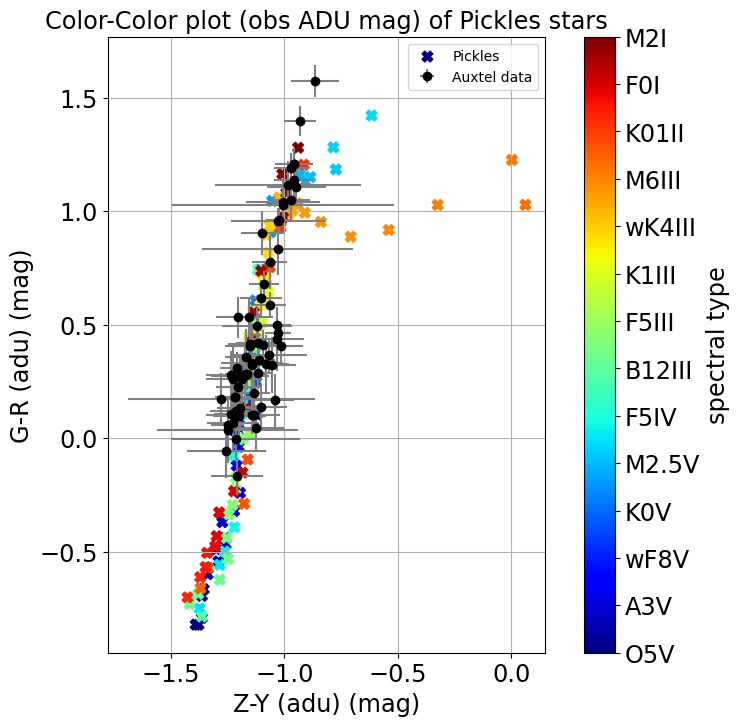

In [44]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

df_out.plot.scatter(x="aduZ_Y",y="aduG_R",marker="X",c="index",s=60,colormap="jet",ax=ax,grid=True,colorbar=False,label="Pickles")
#cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
cbar = plt.colorbar(ax.collections[0],ax=ax)
cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels):
    the_label = int(labels[ilab])
    labels[ilab] = df_out.loc[the_label,"spectype"]
cbar.ax.set_yticklabels(labels,rotation=0);
ax.set_title("Color-Color plot (obs ADU mag) of Pickles stars")
ax.set_xlabel("Z-Y (adu) (mag)")
ax.set_ylabel("G-R (adu) (mag)")
ax.set_aspect("equal")
ax.errorbar(df_data["z_y_ap"],df_data["g_r_ap"],xerr=df_data["sig_z_y_ap"] , yerr=df_data["sig_g_r_ap"], fmt="o",color='k',ecolor="grey",label="Auxtel data")

ax.legend()

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_62038/1661040742.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels,rotation=0);


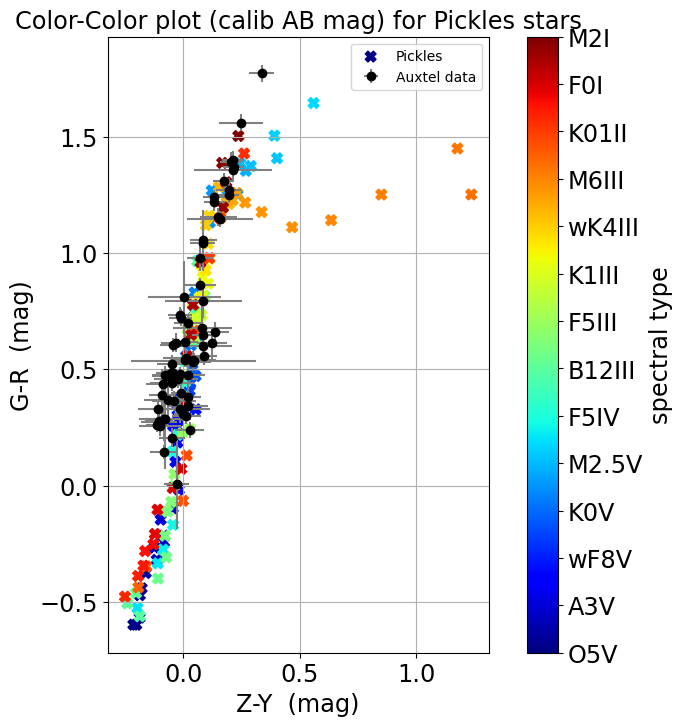

In [45]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
df_out.plot.scatter(x="magZ_Y",y="magG_R",marker="X",c="index",s=60,colormap="jet",ax=ax,grid=True,colorbar=False,label="Pickles")

#cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
cbar = plt.colorbar(ax.collections[0],ax=ax)
cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels):
    the_label = int(labels[ilab])
    labels[ilab] = df_out.loc[the_label,"spectype"]
cbar.ax.set_yticklabels(labels,rotation=0);
ax.set_title("Color-Color plot (calib AB mag) for Pickles stars")
ax.set_xlabel("Z-Y  (mag)")
ax.set_ylabel("G-R  (mag)")
ax.set_aspect("equal")

ax.errorbar(df_data["z_y_psf"],df_data["g_r_psf"],xerr=df_data["sig_z_y_psf"] , yerr=df_data["sig_g_r_psf"], fmt="o",color='k',ecolor="grey",label="Auxtel data")
ax.legend()

## Nearest Neighbourgs

Test 3 methods. All have the same results hopefully !

- NearestNeighbors
- KDTree
- BallTree

In [46]:
df_colors = df_out[["index","spectype","magG_R","magZ_Y"]]

In [47]:
x_pkl = df_colors["magZ_Y"].values
y_pkl = df_colors["magG_R"].values
X_pkl = list(zip(x_pkl,y_pkl))

In [48]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X_pkl)

In [49]:
x_dat = df_data["z_y_psf"].values
y_dat = df_data["g_r_psf"].values
X_dat = list(zip(x_dat,y_dat))

In [50]:
distances, indices = nbrs.kneighbors(X_dat)

In [51]:
indices[:10]

array([[71],
       [37],
       [88],
       [78],
       [54],
       [54],
       [23],
       [36],
       [16],
       [78]])

In [52]:
kdt = KDTree(X_pkl,leaf_size=30, metric='euclidean')
indices = kdt.query(X_dat, k=1, return_distance=False)

In [53]:
indices[:10]

array([[71],
       [37],
       [88],
       [78],
       [54],
       [54],
       [23],
       [36],
       [16],
       [78]])

In [54]:
bt = BallTree(X_pkl, metric='euclidean')
indices = bt.query(X_dat,k=1,return_distance=False)

In [55]:
indices[:10]

array([[71],
       [37],
       [88],
       [78],
       [54],
       [54],
       [23],
       [36],
       [16],
       [78]])

In [59]:
df_data[["z_y_psf","g_r_psf"]].head(n=5)

,z_y_psf,g_r_psf
0,-0.015859,0.480301
1,0.194686,1.247996
2,0.082771,1.042680
3,-0.010560,0.722428
4,-0.049720,0.522499


In [69]:
indices_flat = indices.flatten()

In [70]:
df_colors.iloc[indices_flat].head(5)

,index,spectype,magG_R,magZ_Y
71,71,G0III,0.474265,0.008348
37,37,M0V,1.257396,0.183849
88,88,rK3III,1.039821,0.105998
78,78,wK0III,0.720609,0.044731
54,54,G5IV,0.534788,0.004762


### Choose the data index to check the localtion of the closest Pickle

In [85]:
idx_dat = 3
x0_dat = X_dat[idx_dat][0] 
y0_dat = X_dat[idx_dat][1] 
idx_pkl = indices_flat[idx_dat]
row_pkl= df_colors.loc[idx_pkl] 
x0_pkl = row_pkl["magZ_Y"]
y0_pkl = row_pkl["magG_R"]

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_62038/749425040.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels,rotation=0);


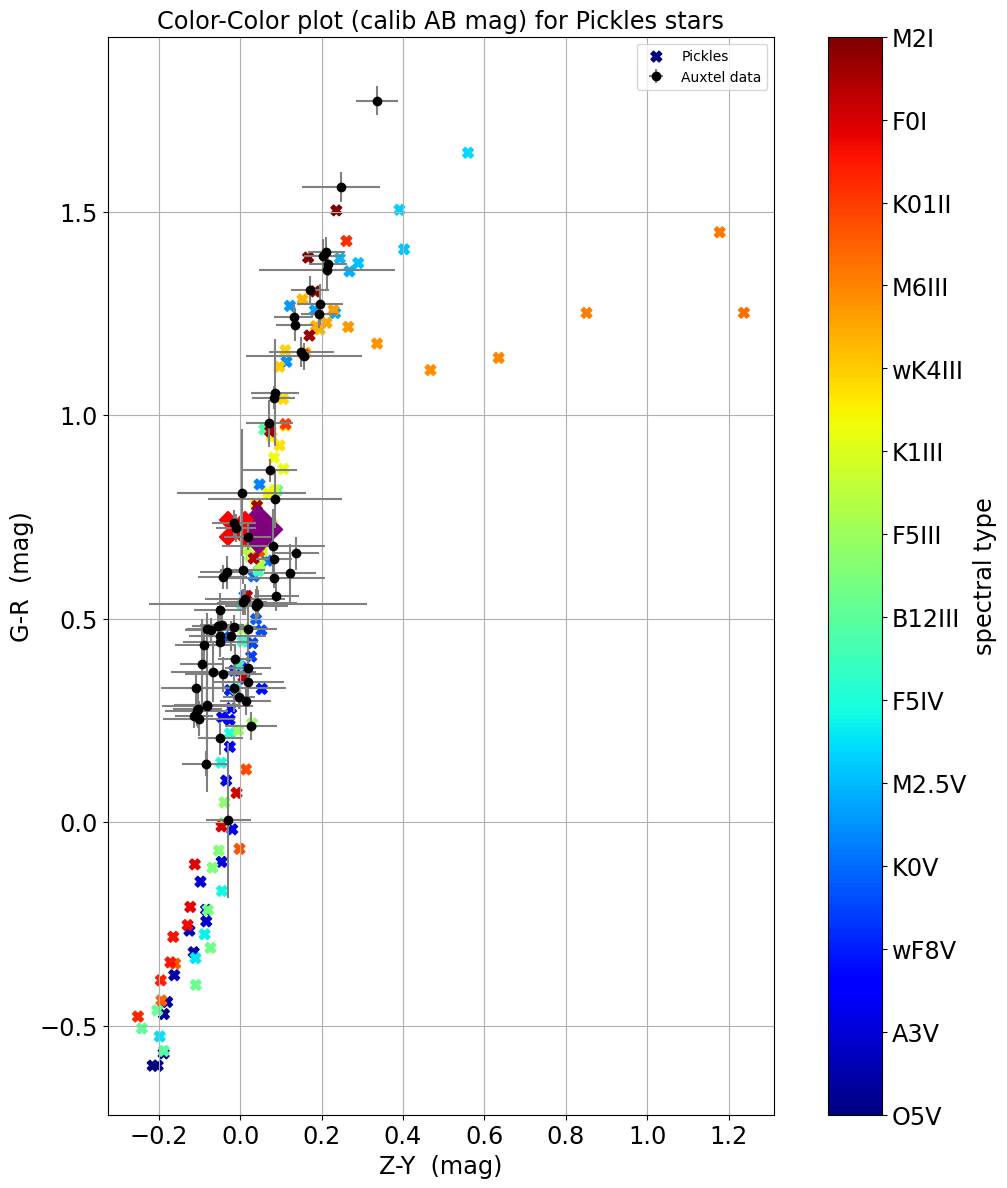

In [90]:
fig,ax = plt.subplots(1,1,figsize=(14,14))
df_out.plot.scatter(x="magZ_Y",y="magG_R",marker="X",c="index",s=60,colormap="jet",ax=ax,grid=True,colorbar=False,label="Pickles")
ax.scatter([x0_pkl],[y0_pkl],s=600,marker="D",color="purple")

#cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
cbar = plt.colorbar(ax.collections[0],ax=ax)
cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels):
    the_label = int(labels[ilab])
    labels[ilab] = df_out.loc[the_label,"spectype"]
cbar.ax.set_yticklabels(labels,rotation=0);
ax.set_title("Color-Color plot (calib AB mag) for Pickles stars")
ax.set_xlabel("Z-Y  (mag)")
ax.set_ylabel("G-R  (mag)")
ax.set_aspect("equal")

ax.errorbar(df_data["z_y_psf"],df_data["g_r_psf"],xerr=df_data["sig_z_y_psf"] , yerr=df_data["sig_g_r_psf"], fmt="o",color='k',ecolor="grey",label="Auxtel data")
ax.scatter([x0_dat],[y0_dat],s=600,marker="X",color="r")
ax.legend()